In [1]:
# In this notebook we will work with CamemBERT model that is
# developed in Inria incollaboration with Facebook and Sorbonne University.UnicodeDecodeError

In [2]:
print('Hello World')

Hello World


In [1]:
# ==== Basic Python / Data Handling ====
import os
import re
import json
import numpy as np
import pandas as pd

# ==== Scikit-Learn Utilities ====
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc


# Matplotlib
import matplotlib.pyplot as plt


# ==== PyTorch ====
import torch
from torch.utils.data import Dataset, DataLoader

# ==== HuggingFace Transformers ====
from transformers import (
    CamembertTokenizer,
    CamembertForSequenceClassification,
    TrainingArguments,
    Trainer
)

# ==== LightGBM (Metadata Model) ====
import lightgbm as lgb

# ==== Progress Bar (optional but recommended) ====
from tqdm import tqdm

# ==== Warnings (optional) ====
import warnings
warnings.filterwarnings("ignore")


c:\Users\Asus\Documents\GitHub\social_dl\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\Asus\Documents\GitHub\social_dl\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\Asus\Documents\GitHub\social_dl\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
def load_jsonl(path):
    """
    Loads a JSONL file into a pandas DataFrame.
    Ensures text column is cleaned and missing values handled.
    """
    df = pd.read_json(path, lines=True)
    # Basic cleaning of tweet text
    def clean_text(t):
        if pd.isna(t):
            return ""
        t = str(t)
        t = t.replace("\n", " ").strip()
        t = re.sub(r"\s+", " ", t)
        return t

    df["text"] = df["text"].apply(clean_text)

    df["has_url"] = df["text"].str.contains(r"http[s]?://", regex=True).astype(int)
    df["num_hashtags"] = df["text"].str.count(r"#")
    df["has_hashtag"] = (df["num_hashtags"] > 0).astype(int)
    df["num_mentions"] = df["text"].str.count(r"@")

    emoji_pattern = r"[\U0001F600-\U0001F64F]"
    df["num_emojis"] = df["text"].str.count(emoji_pattern)

    df["text_len"] = df["text"].str.len()
    df["num_caps"] = df["text"].str.count(r"[A-Z]")
    df["num_exclam"] = df["text"].str.count(r"!")
    df["num_question"] = df["text"].str.count(r"\?")

    promo_words = ["check out", "giveaway", "subscribe", "new video", "promo"]
    df["promo_words"] = df["text"].str.lower().apply(
        lambda t: any(w in t for w in promo_words)
    ).astype(int)

    print("Loaded:", path)
    print("Rows:", len(df))
    return df


# === LOAD TRAIN FILE ===
train_path = "../data/Kaggle2025/train.jsonl"  
df = load_jsonl(train_path)

df.head()


Loaded: ../data/Kaggle2025/train.jsonl
Rows: 154914


,quoted_status,in_reply_to_status_id_str,in_reply_to_status_id,created_at,in_reply_to_user_id_str,source,quoted_status_id,retweet_count,retweeted,geo,...,has_url,num_hashtags,has_hashtag,num_mentions,num_emojis,text_len,num_caps,num_exclam,num_question,promo_words
0,"{'extended_tweet': {'entities': {'urls': [], '...",NaN,NaN,2021-03-17 13:01:59+00:00,NaN,"<a href=""http://twitter.com/download/iphone"" r...",1.372171e+18,0,False,None,...,0,0,0,0,0,23,1,0,0,0
1,"{'extended_tweet': {'entities': {'urls': [], '...",NaN,NaN,2021-03-17 13:02:06+00:00,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.372171e+18,0,False,None,...,0,0,0,0,0,114,4,0,0,0
2,NaN,1.372164e+18,1.372164e+18,2021-03-17 13:02:58+00:00,1.066820e+18,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,0,False,None,...,1,0,0,4,0,139,10,0,0,0
3,NaN,NaN,NaN,2021-03-17 13:03:00+00:00,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,0,False,None,...,1,0,0,2,0,140,17,0,0,0
4,NaN,1.372165e+18,1.372165e+18,2021-03-17 13:03:04+00:00,1.522354e+09,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,0,False,None,...,1,0,0,3,0,140,7,0,0,0


In [3]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df["label"]
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))


Train size: 139422
Val size: 15492


In [4]:


MODEL_NAME = "camembert-base"

tokenizer = CamembertTokenizer.from_pretrained(MODEL_NAME)

class TweetTextDataset(Dataset):
    """
    Dataset for feeding text + labels into CamemBERT.
    """
    def __init__(self, df, text_col="text", label_col="label"):
        self.texts = df[text_col].tolist()
        self.labels = df[label_col].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        enc = tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )

        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

train_text_ds = TweetTextDataset(train_df)
val_text_ds   = TweetTextDataset(val_df)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:

print("Using CUDA:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


model = CamembertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy}

training_args = TrainingArguments(
    output_dir="./camembert_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,       # use 8 if GPU VRAM is limited
    per_device_eval_batch_size=32,
    num_train_epochs=3,                   # Can be increased
    optim="adamw_torch",                  
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=100,
)


# Training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_text_ds,
    eval_dataset=val_text_ds,
    compute_metrics=compute_metrics
)

trainer.train()


eval_results = trainer.evaluate()
eval_results


pred_text = trainer.predict(val_text_ds)
logits_text = torch.tensor(pred_text.predictions)
probs_text_val = torch.softmax(logits_text, dim=-1)[:, 1].numpy()

y_val = val_df["label"].values


Using CUDA: True
Device count: 1
Current device: 0
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/26142 [00:00<?, ?it/s]

{'loss': 0.6812, 'learning_rate': 1.992349475939102e-05, 'epoch': 0.01}
{'loss': 0.6458, 'learning_rate': 1.9846989518782037e-05, 'epoch': 0.02}
{'loss': 0.632, 'learning_rate': 1.9770484278173056e-05, 'epoch': 0.03}
{'loss': 0.6274, 'learning_rate': 1.9693979037564076e-05, 'epoch': 0.05}
{'loss': 0.6227, 'learning_rate': 1.9617473796955095e-05, 'epoch': 0.06}
{'loss': 0.6223, 'learning_rate': 1.954096855634611e-05, 'epoch': 0.07}
{'loss': 0.6175, 'learning_rate': 1.946446331573713e-05, 'epoch': 0.08}
{'loss': 0.6231, 'learning_rate': 1.938795807512815e-05, 'epoch': 0.09}
{'loss': 0.6175, 'learning_rate': 1.9311452834519165e-05, 'epoch': 0.1}
{'loss': 0.6182, 'learning_rate': 1.9234947593910185e-05, 'epoch': 0.11}
{'loss': 0.6086, 'learning_rate': 1.9158442353301204e-05, 'epoch': 0.13}
{'loss': 0.6141, 'learning_rate': 1.908193711269222e-05, 'epoch': 0.14}
{'loss': 0.5988, 'learning_rate': 1.900543187208324e-05, 'epoch': 0.15}
{'loss': 0.6099, 'learning_rate': 1.892892663147426e-05, 'e

  0%|          | 0/485 [00:00<?, ?it/s]

{'eval_loss': 0.587993323802948, 'eval_accuracy': 0.6887425768138394, 'eval_runtime': 182.2915, 'eval_samples_per_second': 84.985, 'eval_steps_per_second': 2.661, 'epoch': 1.0}
{'loss': 0.5606, 'learning_rate': 1.326753882640961e-05, 'epoch': 1.01}
{'loss': 0.5334, 'learning_rate': 1.3191033585800627e-05, 'epoch': 1.02}
{'loss': 0.5592, 'learning_rate': 1.3114528345191646e-05, 'epoch': 1.03}
{'loss': 0.5519, 'learning_rate': 1.3038023104582664e-05, 'epoch': 1.04}
{'loss': 0.5711, 'learning_rate': 1.2961517863973683e-05, 'epoch': 1.06}
{'loss': 0.5591, 'learning_rate': 1.2885012623364701e-05, 'epoch': 1.07}
{'loss': 0.5686, 'learning_rate': 1.2808507382755719e-05, 'epoch': 1.08}
{'loss': 0.5522, 'learning_rate': 1.2732002142146738e-05, 'epoch': 1.09}
{'loss': 0.5676, 'learning_rate': 1.2655496901537756e-05, 'epoch': 1.1}
{'loss': 0.546, 'learning_rate': 1.2578991660928775e-05, 'epoch': 1.11}
{'loss': 0.5592, 'learning_rate': 1.2502486420319793e-05, 'epoch': 1.12}
{'loss': 0.5501, 'learn

  0%|          | 0/485 [00:00<?, ?it/s]

Checkpoint destination directory ./camembert_output\checkpoint-17428 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.585938572883606, 'eval_accuracy': 0.6950038729666925, 'eval_runtime': 182.3657, 'eval_samples_per_second': 84.95, 'eval_steps_per_second': 2.659, 'epoch': 2.0}
{'loss': 0.5227, 'learning_rate': 6.6115828934282e-06, 'epoch': 2.01}
{'loss': 0.4873, 'learning_rate': 6.535077652819218e-06, 'epoch': 2.02}
{'loss': 0.5008, 'learning_rate': 6.458572412210237e-06, 'epoch': 2.03}
{'loss': 0.5309, 'learning_rate': 6.382067171601255e-06, 'epoch': 2.04}
{'loss': 0.484, 'learning_rate': 6.305561930992274e-06, 'epoch': 2.05}
{'loss': 0.4786, 'learning_rate': 6.229056690383291e-06, 'epoch': 2.07}
{'loss': 0.4721, 'learning_rate': 6.15255144977431e-06, 'epoch': 2.08}
{'loss': 0.5003, 'learning_rate': 6.076046209165328e-06, 'epoch': 2.09}
{'loss': 0.4943, 'learning_rate': 5.999540968556347e-06, 'epoch': 2.1}
{'loss': 0.5178, 'learning_rate': 5.923035727947365e-06, 'epoch': 2.11}
{'loss': 0.5427, 'learning_rate': 5.846530487338383e-06, 'epoch': 2.12}
{'loss': 0.5156, 'learning_rate': 5.7

  0%|          | 0/485 [00:00<?, ?it/s]

{'eval_loss': 0.6131271123886108, 'eval_accuracy': 0.6959075651949393, 'eval_runtime': 182.619, 'eval_samples_per_second': 84.832, 'eval_steps_per_second': 2.656, 'epoch': 3.0}
{'train_runtime': 17095.7639, 'train_samples_per_second': 24.466, 'train_steps_per_second': 1.529, 'train_loss': 0.552255776196447, 'epoch': 3.0}


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

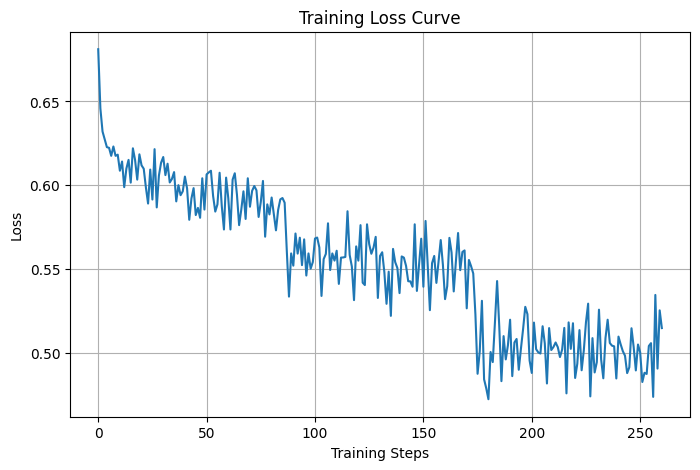

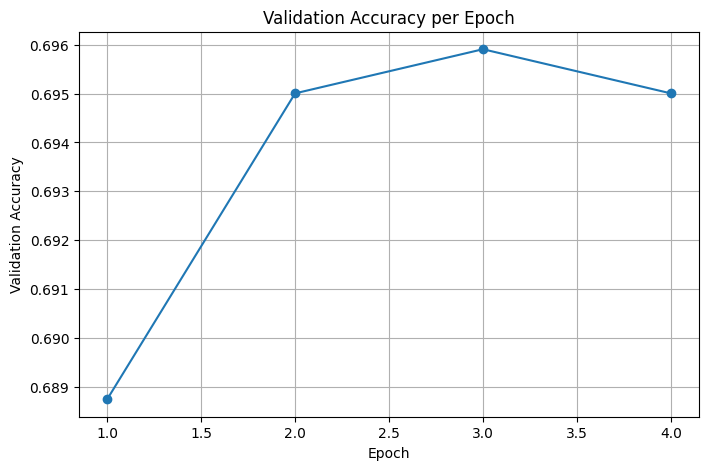

In [8]:

logs = trainer.state.log_history

train_loss = [x["loss"] for x in logs if "loss" in x]
steps = list(range(len(train_loss)))

plt.figure(figsize=(8, 5))
plt.plot(steps, train_loss)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


val_acc = [x["eval_accuracy"] for x in logs if "eval_accuracy" in x]
epochs = list(range(1, len(val_acc) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, val_acc, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.grid(True)
plt.show()



In [5]:
def flatten_record(prefix, obj, out_dict):
    """
    Recursively flatten a nested JSON object.
    Lists become length-only features.
    """
    if isinstance(obj, dict):
        for k, v in obj.items():
            new_key = f"{prefix}_{k}" if prefix else k
            flatten_record(new_key, v, out_dict)
    elif isinstance(obj, list):
        out_dict[prefix + "_len"] = len(obj)
    else:
        out_dict[prefix] = obj


def extract_features_from_row(row):
    """
    Flatten all metadata for a single row.
    Excludes 'text' and 'label'.
    """
    feature_dict = {}
    for col in row.index:
        if col in ["text", "label"]:
            continue
        val = row[col]
        flatten_record(col, val, feature_dict)
    return feature_dict


def build_metadata_dataframe(df):
    """
    Flatten metadata for entire dataset.
    """
    records = []
    for _, row in df.iterrows():
        records.append(extract_features_from_row(row))
    meta_df = pd.DataFrame(records)
    return meta_df



meta_train = build_metadata_dataframe(train_df)
meta_val   = build_metadata_dataframe(val_df)

print("Train meta shape:", meta_train.shape)
print("Val meta shape:", meta_val.shape)
meta_train.head()


nunique = meta_train.nunique()
constant_cols = nunique[nunique <= 1].index.tolist()

meta_train = meta_train.drop(columns=constant_cols, errors="ignore")
meta_val   = meta_val.drop(columns=constant_cols, errors="ignore")

print("Removed constant cols:", constant_cols)


sparse_cols = meta_train.columns[meta_train.isna().mean() > 0.97].tolist()

meta_train = meta_train.drop(columns=sparse_cols, errors="ignore")
meta_val   = meta_val.drop(columns=sparse_cols, errors="ignore")

print("Removed sparse cols:", sparse_cols)


meta_train = meta_train.fillna(-1)
meta_val   = meta_val.fillna(-1)


datetime_cols = meta_train.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns
meta_train = meta_train.drop(columns=datetime_cols, errors="ignore")
meta_val   = meta_val.drop(columns=datetime_cols, errors="ignore")
print("Dropped datetime cols:", list(datetime_cols))


object_cols = meta_train.select_dtypes(include=["object"]).columns
meta_train = meta_train.drop(columns=object_cols, errors="ignore")
meta_val   = meta_val.drop(columns=object_cols, errors="ignore")
print("Dropped object cols:", len(object_cols))


meta_train = meta_train.apply(pd.to_numeric, errors="ignore")
meta_val   = meta_val.apply(pd.to_numeric, errors="ignore")


meta_train = meta_train.fillna(-1)
meta_val   = meta_val.fillna(-1)


print("Final meta_train:", meta_train.shape)
print("Final meta_val:", meta_val.shape)




Train meta shape: (139422, 201)
Val meta shape: (15492, 199)
Removed constant cols: ['quoted_status', 'retweet_count', 'retweeted', 'geo', 'filter_level', 'favorite_count', 'place', 'quoted_status_permalink', 'lang', 'quote_count', 'favorited', 'coordinates', 'reply_count', 'contributors', 'user_utc_offset', 'user_default_profile_image', 'user_protected', 'user_lang', 'user_time_zone', 'user_contributors_enabled', 'user_follow_request_sent', 'user_following', 'user_notifications', 'extended_tweet', 'display_text_range', 'extended_entities', 'withheld_in_countries', 'extended_tweet_display_text_range_len', 'display_text_range_len', 'quoted_status_extended_tweet_display_text_range_len', 'quoted_status_retweeted', 'quoted_status_geo', 'quoted_status_filter_level', 'quoted_status_place', 'quoted_status_favorited', 'quoted_status_coordinates', 'quoted_status_contributors', 'quoted_status_user_utc_offset', 'quoted_status_user_default_profile_image', 'quoted_status_user_protected', 'quoted_st

In [6]:

train_dataset = lgb.Dataset(meta_train, label=train_df["label"])
val_dataset   = lgb.Dataset(meta_val, label=val_df["label"])

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 80,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
}

model_meta = lgb.train(
    params,
    train_dataset,
    valid_sets=[val_dataset],
    num_boost_round=2000,

)

probs_meta_val = model_meta.predict(meta_val, num_iteration=model_meta.best_iteration)


weights = np.linspace(0, 1, 21)  # 0.0, 0.05, ..., 1.0
best_acc = 0
best_w = None

for w in weights:
    p_final = w * probs_text_val + (1 - w) * probs_meta_val
    preds = (p_final >= 0.5).astype(int)
    acc = (preds == y_val).mean()
    if acc > best_acc:
        best_acc = acc
        best_w = w

print("Best weight:", best_w)
print("Best validation accuracy:", best_acc)


[LightGBM] [Info] Number of positive: 65016, number of negative: 74406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5938
[LightGBM] [Info] Number of data points in the train set: 139422, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.466325 -> initscore=-0.134903
[LightGBM] [Info] Start training from score -0.134903


NameError: name 'probs_text_val' is not defined

In [7]:


val_acc = [x["eval_accuracy"] for x in logs if "eval_accuracy" in x]
epochs = list(range(1, len(val_acc) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, val_acc, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.grid(True)
plt.show()




pred_labels = np.argmax(pred_text.predictions, axis=1)

cm = confusion_matrix(y_val, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Validation Set)")
plt.show()



fpr, tpr, _ = roc_curve(y_val, probs_text_val)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Text Model")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'logs' is not defined

In [ ]:
# merge train + val for final training

print("Using CUDA:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


full_df = df.copy()   # df is your original train.jsonl loaded

final_text_ds = TweetTextDataset(full_df)

model = CamembertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

training_args = TrainingArguments(
    output_dir="./final_camembert",
    evaluation_strategy="no",     # no val set now
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=2,           # increase!
    weight_decay=0.01,
    logging_steps=200,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_text_ds
)

trainer.train()


Using CUDA: True
Device count: 1
Current device: 0
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/29049 [00:00<?, ?it/s]

{'loss': 0.6681, 'learning_rate': 1.9862301628283247e-05, 'epoch': 0.02}
{'loss': 0.6257, 'learning_rate': 1.9724603256566492e-05, 'epoch': 0.04}
{'loss': 0.625, 'learning_rate': 1.9586904884849737e-05, 'epoch': 0.06}
{'loss': 0.6167, 'learning_rate': 1.9449206513132983e-05, 'epoch': 0.08}
{'loss': 0.6186, 'learning_rate': 1.9311508141416228e-05, 'epoch': 0.1}
{'loss': 0.6145, 'learning_rate': 1.9173809769699473e-05, 'epoch': 0.12}
{'loss': 0.6182, 'learning_rate': 1.903611139798272e-05, 'epoch': 0.14}
{'loss': 0.6058, 'learning_rate': 1.8898413026265964e-05, 'epoch': 0.17}
{'loss': 0.5874, 'learning_rate': 1.8760714654549213e-05, 'epoch': 0.19}
{'loss': 0.6067, 'learning_rate': 1.8623016282832458e-05, 'epoch': 0.21}
{'loss': 0.5963, 'learning_rate': 1.8485317911115703e-05, 'epoch': 0.23}
{'loss': 0.5988, 'learning_rate': 1.834761953939895e-05, 'epoch': 0.25}
{'loss': 0.6159, 'learning_rate': 1.8209921167682194e-05, 'epoch': 0.27}
{'loss': 0.6066, 'learning_rate': 1.807222279596544e-05

TrainOutput(global_step=29049, training_loss=0.5510742841207976, metrics={'train_runtime': 18622.3532, 'train_samples_per_second': 24.956, 'train_steps_per_second': 1.56, 'train_loss': 0.5510742841207976, 'epoch': 3.0})

In [11]:
os.getcwd()

'c:\\Users\\Asus\\Documents\\GitHub\\social_dl\\notebooks'

In [ ]:
# load test set
test_df = load_jsonl("..\data\kaggle_test.jsonl")



class TweetTextDatasetTest(Dataset):
    """
    Dataset for feeding ONLY text (no labels) into CamemBERT.
    """
    def __init__(self, df, text_col="text"):
        self.texts = df[text_col].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        enc = tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )

        return {k: v.squeeze(0) for k, v in enc.items()}

# text dataset only
test_text_ds = TweetTextDatasetTest(test_df)


pred_text = trainer.predict(test_text_ds)
logits_test = torch.tensor(pred_text.predictions)
probs_text_test = torch.softmax(logits_test, dim=-1)[:, 1].numpy()


meta_test = build_metadata_dataframe(test_df)

# drop same columns you dropped before
meta_test = meta_test.drop(columns=constant_cols, errors="ignore")
meta_test = meta_test.drop(columns=sparse_cols, errors="ignore")
meta_test = meta_test.drop(columns=datetime_cols, errors="ignore")
meta_test = meta_test.drop(columns=object_cols, errors="ignore")

meta_test = meta_test.apply(pd.to_numeric, errors="ignore").fillna(-1)

missing_cols = [c for c in meta_train.columns if c not in meta_test.columns]
for c in missing_cols:
    meta_test[c] = 0 

extra_cols = [c for c in meta_test.columns if c not in meta_train.columns]
meta_test = meta_test.drop(columns=extra_cols)

meta_test = meta_test[meta_train.columns]

probs_meta_test = model_meta.predict(meta_test, num_iteration=model_meta.best_iteration)

best_w = 0.3500008

meta_test.shape == meta_train.shape

p_final_test = best_w * probs_text_test + (1 - best_w) * probs_meta_test
preds_test = (p_final_test >= 0.5).astype(int)

Loaded: ..\data\kaggle_test.jsonl
Rows: 103380


  0%|          | 0/12923 [00:00<?, ?it/s]

In [ ]:
sub = pd.DataFrame({
    "ID": test_df["challenge_id"],   # check file column name!
    "Prediction": preds_test
})

sub.to_csv("BERT_submission.csv", index=False)
print("Saved final_submission.csv")


Saved final_submission.csv
